In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("mfd/data/mf_corpora_merged.csv", index_col=0)
news = data.iloc[:34262,:]
reddit = data.iloc[34262:34262 + 17886, :]
twitter = data.iloc[34262 + 17886:, :]

## Number of tokens

In [3]:
import spacy
nlp = spacy.load("en_core_web_md")

In [4]:
from tqdm import tqdm
num_toks = [len(doc) for doc in tqdm(nlp.pipe(data["sentence"], n_process=-1))]

87135it [01:10, 1239.61it/s]


In [5]:
data["num_tokens"] = num_toks

In [7]:
print("Total numer of tokens:", data["num_tokens"].sum())

Total numer of tokens: 2380497


In [8]:
data["num_tokens"].describe()

count    87135.000000
mean        27.319642
std         17.775816
min          2.000000
25%         16.000000
50%         23.000000
75%         33.000000
max        202.000000
Name: num_tokens, dtype: float64

In [9]:
news = data.iloc[:34262,:]
reddit = data.iloc[34262:34262 + 17886, :]
twitter = data.iloc[34262 + 17886:, :]

In [10]:
found_count = data[["authority_label", "care_label", "fairness_label", "loyalty_label", "sanctity_label"]].to_numpy().copy()
found_count[found_count < 0] = 0

data["num_labels"] = found_count.sum(1)

In [11]:
news = data.iloc[:34262,:]
reddit = data.iloc[34262:34262 + 17886, :]
twitter = data.iloc[34262 + 17886:, :]

In [12]:
import scipy.stats as st
import seaborn as sns
def mean_ci(x, ci=0.95):
    mean = np.mean(x)
    itv = st.t.interval(confidence=ci, df=len(x)-1, loc=mean, scale=st.sem(x))
    return mean, itv

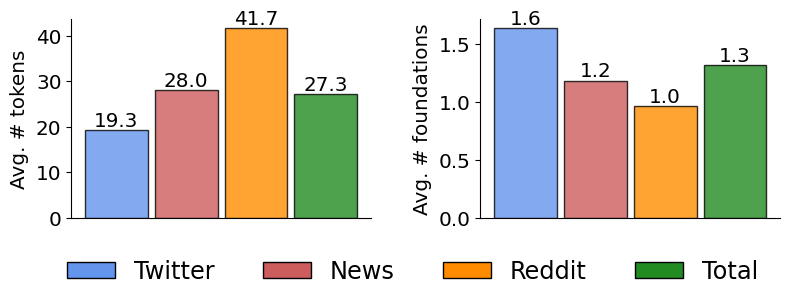

In [13]:
mean_toks = [mean_ci(x)[0] for x in [twitter.num_tokens, news.num_tokens, reddit.num_tokens, data.num_tokens]]
yerrs = [mean_ci(x)[1] for x in [twitter.num_tokens, news.num_tokens, reddit.num_tokens, data.num_tokens]]
yerrs = [0.5 * (x[1] - x[0]) for x in yerrs]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5))
# ax1.grid(axis="y", alpha=0.5)
ax1.set_xticks([])
for i, val in enumerate(mean_toks):
    ax1.text(x=i, y=val + 2, s=f"{val:.1f}", va="center", ha="center", size="x-large")
ax1.bar(np.arange(4), mean_toks, 
        # yerr=yerrs, capsize=7, 
        color=["cornflowerblue", "indianred", "darkorange", "forestgreen"],
        hatch=[None], alpha=0.8, edgecolor="black", width=0.9)
ax1.tick_params(axis="y", which='major', labelsize="x-large")
ax1.set_yticks([0, 10, 20, 30, 40])
ax1.set_ylabel("Avg. # tokens", size="x-large", labelpad=5)

mean_num_labels = [mean_ci(x)[0] for x in [twitter.num_labels, news.num_labels, reddit.num_labels, data.num_labels]]
yerrs = [mean_ci(x)[1] for x in [twitter.num_labels, news.num_labels, reddit.num_labels, data.num_labels]]
yerrs = [0.5 * (x[1] - x[0]) for x in yerrs]
# ax2.grid(axis="y", alpha=0.5)
for i, val in enumerate(mean_num_labels):
    ax2.text(x=i, y=val + 0.08, s=f"{val:.1f}", va="center", ha="center", size="x-large")
ax2.set_xticks([])
ax2.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
ax2.tick_params(axis="y", which='major', labelsize="x-large")
ax2.bar(np.arange(4), mean_num_labels, 
        # yerr=yerrs, capsize=7, 
        color=["cornflowerblue", "indianred", "darkorange", "forestgreen"],
        hatch=[None], alpha=0.8, edgecolor="black", width=0.9)
ax2.set_ylabel("Avg. # foundations", size="x-large", labelpad=5)

fig.tight_layout(w_pad=3)

sns.despine()

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [ 
    Patch(facecolor='cornflowerblue', edgecolor='black', label='Twitter'),
    Patch(facecolor='indianred', edgecolor='black', label='News'),
    Patch(facecolor='darkorange', edgecolor='black', label='Reddit'),
    Patch(facecolor='forestgreen', edgecolor='black', label='Total'),
]
ax2.legend(handles=legend_elements, loc='best', 
           bbox_to_anchor=(1, -0.1),
           fontsize="xx-large", 
           title_fontsize="x-large", ncol=4,
           frameon=False)

plt.savefig("figs/mf_dataset_stats.pdf", bbox_inches="tight")

## Dataset period

### News

In [14]:
coded_news = pd.read_pickle("mfd/data/coded_news.pkl")

In [23]:
# Extract date
import re
def extract_date(url):
        return re.findall(r'/(\d{4})/(\d{1,2})/(\d{1,2})/', url)

In [24]:
from datetime import datetime
dates = coded_news.url.map(extract_date).tolist()

In [26]:
dates = [(int(d[0][0]), int(d[0][1]), int(d[0][2])) for d in dates if len(d) > 0]
dates = [datetime(*x) for x in dates]

Number of articles containing dates / total articles

In [28]:
len(dates) / len(coded_news)

0.5683168316831683

Minimum and maximum dates

In [29]:
min(dates)

datetime.datetime(2012, 7, 9, 0, 0)

In [30]:
max(dates)

datetime.datetime(2017, 1, 30, 0, 0)

### Twitter

In [31]:
import json
with open("mfd/data/MFTC_V4_text.json", 'r') as f:
    mftc = json.load(f)

In [32]:
from utils import tweetid2time

In [35]:
dates = []
for corpus in mftc:
    for tweet in corpus["Tweets"]:
        dates.append(tweetid2time(tweet["tweet_id"]))

In [37]:
min(dates)

(2010, 11, 4)

In [38]:
max(dates)

(2017, 3, 23)

### Reddit

Check paper

## Percentage of examples containing each moral foundation

In [68]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

In [92]:
data = pd.read_csv("mfd/data/mf_corpora_merged.csv", index_col=0)
news = data.iloc[:34262,:]
reddit = data.iloc[34262:34262 + 17886, :]
twitter = data.iloc[34262 + 17886:, :]

In [119]:
def get_labels_and_scores(foundation, corpus="all"):
    assert corpus in ["twitter", "reddit", "news", "all"]
    if corpus == "news": data_f = data.iloc[:34262,:]
    elif corpus == "reddit": data_f = data.iloc[34262:34262 + 17886, :]
    elif corpus == "twitter": data_f = data.iloc[34262 + 17886:, :]
    else: data_f = data
    # Remove examples without annotations
    # data_f = data_f[data_f[f"{foundation}_fold"] != -1]
    return data_f

In [120]:
corpora = ["twitter", "news", "reddit", "all"]
df = pd.DataFrame(0, index=FOUNDATIONS, columns=corpora)
for foundation in FOUNDATIONS:
    for corpus in corpora:
        data_f = get_labels_and_scores(foundation=foundation, 
                                       corpus=corpus)
        col = data_f[foundation + "_label"].to_numpy()
        if -1 in col:
            print(corpus)
        col[col == -1] = 0
        df.loc[foundation, corpus] = col.sum() / data_f.shape[0]

In [123]:
np.round(df * 100, 1)

,twitter,news,reddit,all
authority,33.4,24.9,19.2,27.1
care,40.6,24.8,26.5,31.5
fairness,35.9,24.2,29.5,30.0
loyalty,31.1,24.4,11.1,24.4
sanctity,22.3,19.9,9.8,18.8
